In [ ]:
# Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as st
from volsense_core.models.global_vol_forecaster import (
    TrainConfig,
    train_global_model
)

In [2]:
# ---------- 0) Load & feature engineering ----------
EPS = 1e-6
multi_df = pd.read_csv("../data/processed/global_lstm_dataset_v2.csv")
multi_df["date"] = pd.to_datetime(multi_df["date"], errors="coerce")
multi_df = multi_df.dropna(subset=["date"]).sort_values(["ticker","date"]).reset_index(drop=True)

multi_df["realized_vol_log"] = np.log(multi_df["realized_vol"] + EPS)
g = multi_df.groupby("ticker", group_keys=False)

# Rolling volatility features
multi_df["vol_3d"]    = g["realized_vol"].apply(lambda s: s.rolling(3,  min_periods=1).mean())
multi_df["vol_10d"]   = g["realized_vol"].apply(lambda s: s.rolling(10, min_periods=1).mean())
multi_df["vol_ratio"] = multi_df["vol_3d"] / (multi_df["vol_10d"] + EPS)
multi_df["vol_chg"]   = multi_df["vol_3d"] - multi_df["vol_10d"]
multi_df["vol_vol"]   = g["realized_vol"].apply(lambda s: s.rolling(10, min_periods=2).std())

# Long-term memory proxy
multi_df["ewma_vol_10d"] = g["realized_vol"].apply(lambda s: s.ewm(span=10, adjust=False).mean())

# Market stress, skew, calendar
multi_df["market_stress"] = multi_df.groupby("date")["return"].transform(lambda x: x.std())
multi_df["market_stress_1d_lag"] = g["market_stress"].shift(1)

def _skew5(x):
    if len(x) < 3: return np.nan
    m, sd = np.mean(x), np.std(x)
    sd = sd if sd > 0 else EPS
    return np.mean(((x - m)/sd)**3)
multi_df["skew_5d"] = g["return"].apply(lambda s: s.rolling(5, min_periods=3).apply(_skew5, raw=True))

multi_df["day_of_week"] = multi_df["date"].dt.dayofweek / 6.0
multi_df["abs_return"] = multi_df["return"].abs()

multi_df = multi_df.groupby("ticker", group_keys=False).apply(lambda d: d.ffill().bfill()).reset_index(drop=True)

C:\Users\rahul\AppData\Local\Temp\ipykernel_48584\1988799655.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  multi_df = multi_df.groupby("ticker", group_keys=False).apply(lambda d: d.ffill().bfill()).reset_index(drop=True)


In [ ]:
# ---------- 1) Config ----------
multi_df.drop(columns=["day_of_week"], inplace=True)  # removing day_of_week feature

HORIZONS = [1,5,10]
EXTRA_FEATURES = [
    "vol_3d","vol_10d","vol_ratio","vol_chg","vol_vol","ewma_vol_10d",
    "market_stress","market_stress_1d_lag","skew_5d","abs_return"
]

cfg = TrainConfig(
    window=40,
    horizons=HORIZONS,
    stride=3,
    val_start="2023-10-10",
    target_col="realized_vol_log",
    extra_features=EXTRA_FEATURES,
    epochs=30,
    lr=2.5e-4,
    batch_size=256,
    cosine_schedule=True,
    oversample_high_vol=False,
    device="cpu",
    dropout=0.35,
    use_layernorm=True,
    separate_heads=True,
    loss_horizon_weights=[0.55,0.25,0.20],
    dynamic_window_jitter=5,
    grad_clip=1.0,
    num_workers=0,
    pin_memory=False
)

# ---------- 2) Train ----------
model, hist, val_loader, ticker_to_id, scalers, features = train_global_model(multi_df, cfg)
print(f"\n✅ Trained on {len(ticker_to_id)} tickers | Horizons={HORIZONS}")
print(f"📉 Final Train: {hist['train'][-1]:.4f} | Val: {hist['val'][-1]:.4f}")


🚀 Training GlobalVolForecaster on 109 tickers...

Epoch 1/30 | Train Loss: 0.0415 | Val Loss: 0.0229
Epoch 2/30 | Train Loss: 0.0241 | Val Loss: 0.0195
Epoch 3/30 | Train Loss: 0.0217 | Val Loss: 0.0178
Epoch 4/30 | Train Loss: 0.0195 | Val Loss: 0.0164
Epoch 5/30 | Train Loss: 0.0172 | Val Loss: 0.0153
Epoch 6/30 | Train Loss: 0.0164 | Val Loss: 0.0149
Epoch 7/30 | Train Loss: 0.0154 | Val Loss: 0.0146
Epoch 8/30 | Train Loss: 0.0153 | Val Loss: 0.0145
Epoch 9/30 | Train Loss: 0.0168 | Val Loss: 0.0144
Epoch 10/30 | Train Loss: 0.0159 | Val Loss: 0.0140
Epoch 11/30 | Train Loss: 0.0153 | Val Loss: 0.0137
Epoch 12/30 | Train Loss: 0.0143 | Val Loss: 0.0136
Epoch 13/30 | Train Loss: 0.0140 | Val Loss: 0.0136
Epoch 14/30 | Train Loss: 0.0134 | Val Loss: 0.0135
Epoch 15/30 | Train Loss: 0.0132 | Val Loss: 0.0135
Epoch 16/30 | Train Loss: 0.0151 | Val Loss: 0.0135
Epoch 17/30 | Train Loss: 0.0146 | Val Loss: 0.0134
Epoch 18/30 | Train Loss: 0.0138 | Val Loss: 0.0133
Epoch 19/30 | Train Lo

In [4]:
# --- 4) Save checkpoint + metadata + pickle --------------------------

os.makedirs("checkpoints", exist_ok=True)

base = "checkpoints/global_vol_forecaster_multi_v6a"
ckpt_path = f"{base}.pth"
meta_path = f"{base}.meta.json"
full_pkl_path = f"{base}_full.pkl"
bundle_pkl_path = f"{base}_bundle.pkl"

# 1) Weights checkpoint
torch.save(model.state_dict(), ckpt_path)

# 2) Metadata JSON
config_dict = {
    "window": cfg.window,
    "stride": cfg.stride,
    "val_start": cfg.val_start,
    "batch_size": cfg.batch_size,
    "lr": cfg.lr,
    "epochs": cfg.epochs,
    "device": cfg.device,
    "cosine_schedule": cfg.cosine_schedule,
    "oversample_high_vol": cfg.oversample_high_vol,
    "target_col": cfg.target_col,
}
with open(meta_path, "w") as f:
    json.dump({
        "ticker_to_id": ticker_to_id,
        "features": features,
        "horizons": HORIZONS,
        "config": config_dict,
    }, f, indent=2)

# 3) Full model pickle (architecture + weights; requires same module path on load)
with open(full_pkl_path, "wb") as f:
    pickle.dump(model, f)

# 4) Portable bundle pickle (state_dict + metadata; more robust to refactors)
bundle = {
    "arch": model.__class__.__name__,
    "module_path": model.__class__.__module__,
    "state_dict": {k: v.cpu() for k, v in model.state_dict().items()},
    "ticker_to_id": ticker_to_id,
    "features": features,
    "horizons": HORIZONS,
    "scalers": scalers,
    "config": config_dict,
}
with open(bundle_pkl_path, "wb") as f:
    pickle.dump(bundle, f)

print(f"💾 Saved checkpoint -> {ckpt_path}")
print(f"💾 Saved metadata   -> {meta_path}")
print(f"💾 Saved full pkl   -> {full_pkl_path}")
print(f"💾 Saved bundle pkl -> {bundle_pkl_path}")

💾 Saved checkpoint -> checkpoints/global_vol_forecaster_multi_v6a.pth
💾 Saved metadata   -> checkpoints/global_vol_forecaster_multi_v6a.meta.json
💾 Saved full pkl   -> checkpoints/global_vol_forecaster_multi_v6a_full.pkl
💾 Saved bundle pkl -> checkpoints/global_vol_forecaster_multi_v6a_bundle.pkl


In [5]:
# ========= v6-B Calm slice: 2012-01-01 to 2013-12-31 =========
HORIZONS = [1,5,10]
EXTRA_FEATURES = [
    "vol_3d","vol_10d","vol_ratio","vol_chg","vol_vol","ewma_vol_10d",
    "market_stress","market_stress_1d_lag","skew_5d","abs_return"
]

cfg_B = TrainConfig(
    window=40,
    horizons=HORIZONS,
    stride=3,
    # causal fields are ignored when val_mode='holdout_slice'
    val_start="2012-01-01",
    val_end="2013-12-31",
    embargo_days=60,
    target_col="realized_vol_log",
    extra_features=EXTRA_FEATURES,
    # training
    epochs=30, lr=2.5e-4, batch_size=256,
    cosine_schedule=True, oversample_high_vol=False, device="cpu",
    dropout=0.35, use_layernorm=True, separate_heads=True,
    loss_horizon_weights=[0.55,0.25,0.20],
    dynamic_window_jitter=5, grad_clip=1.0,
    num_workers=0, pin_memory=False,
    # validation mode
    val_mode="holdout_slice"
)

model_B, hist_B, val_loader_B, t2id_B, scalers_B, feats_B = train_global_model(multi_df, cfg_B)
print(f"\n✅ v6-B trained | Horizons={HORIZONS}")
print(f"📉 Train: {hist_B['train'][-1]:.4f} | Val: {hist_B['val'][-1]:.4f}")


🚀 Training GlobalVolForecaster on 109 tickers...

Epoch 1/30 | Train Loss: 0.0429 | Val Loss: 0.0176
Epoch 2/30 | Train Loss: 0.0255 | Val Loss: 0.0159
Epoch 3/30 | Train Loss: 0.0228 | Val Loss: 0.0147
Epoch 4/30 | Train Loss: 0.0209 | Val Loss: 0.0133
Epoch 5/30 | Train Loss: 0.0186 | Val Loss: 0.0123
Epoch 6/30 | Train Loss: 0.0173 | Val Loss: 0.0117
Epoch 7/30 | Train Loss: 0.0164 | Val Loss: 0.0115
Epoch 8/30 | Train Loss: 0.0163 | Val Loss: 0.0114
Epoch 9/30 | Train Loss: 0.0169 | Val Loss: 0.0111
Epoch 10/30 | Train Loss: 0.0165 | Val Loss: 0.0108
Epoch 11/30 | Train Loss: 0.0156 | Val Loss: 0.0105
Epoch 12/30 | Train Loss: 0.0163 | Val Loss: 0.0104
Epoch 13/30 | Train Loss: 0.0151 | Val Loss: 0.0103
Epoch 14/30 | Train Loss: 0.0142 | Val Loss: 0.0102
Epoch 15/30 | Train Loss: 0.0145 | Val Loss: 0.0102
Epoch 16/30 | Train Loss: 0.0167 | Val Loss: 0.0105
Epoch 17/30 | Train Loss: 0.0153 | Val Loss: 0.0104
Epoch 18/30 | Train Loss: 0.0156 | Val Loss: 0.0102
Epoch 19/30 | Train Lo

In [6]:
# --- 4) Save checkpoint + metadata + pickle --------------------------
import pickle

os.makedirs("checkpoints", exist_ok=True)

base = "checkpoints/global_vol_forecaster_multi_v6B"
ckpt_path = f"{base}.pth"
meta_path = f"{base}.meta.json"
full_pkl_path = f"{base}_full.pkl"
bundle_pkl_path = f"{base}_bundle.pkl"

# 1) Weights checkpoint
torch.save(model.state_dict(), ckpt_path)

# 2) Metadata JSON
config_dict = {
    "window": cfg_B.window,
    "stride": cfg_B.stride,
    "val_start": cfg_B.val_start,
    "batch_size": cfg_B.batch_size,
    "lr": cfg_B.lr,
    "epochs": cfg_B.epochs,
    "device": cfg_B.device,
    "cosine_schedule": cfg_B.cosine_schedule,
    "oversample_high_vol": cfg_B.oversample_high_vol,
    "target_col": cfg_B.target_col,
}
with open(meta_path, "w") as f:
    json.dump({
        "ticker_to_id": t2id_B,
        "features": feats_B,
        "horizons": HORIZONS,
        "config": config_dict,
    }, f, indent=2)

# 3) Full model pickle (architecture + weights; requires same module path on load)
with open(full_pkl_path, "wb") as f:
    pickle.dump(model_B, f)

# 4) Portable bundle pickle (state_dict + metadata; more robust to refactors)
bundle = {
    "arch": model_B.__class__.__name__,
    "module_path": model_B.__class__.__module__,
    "state_dict": {k: v.cpu() for k, v in model_B.state_dict().items()},
    "ticker_to_id": t2id_B,
    "features": feats_B,
    "horizons": HORIZONS,
    "scalers": scalers_B,
    "config": config_dict,
}
with open(bundle_pkl_path, "wb") as f:
    pickle.dump(bundle, f)

print(f"💾 Saved checkpoint -> {ckpt_path}")
print(f"💾 Saved metadata   -> {meta_path}")
print(f"💾 Saved full pkl   -> {full_pkl_path}")
print(f"💾 Saved bundle pkl -> {bundle_pkl_path}")

💾 Saved checkpoint -> checkpoints/global_vol_forecaster_multi_v6B.pth
💾 Saved metadata   -> checkpoints/global_vol_forecaster_multi_v6B.meta.json
💾 Saved full pkl   -> checkpoints/global_vol_forecaster_multi_v6B_full.pkl
💾 Saved bundle pkl -> checkpoints/global_vol_forecaster_multi_v6B_bundle.pkl


In [8]:
# ========= v6-C Volatile slice: 2020-03-01 to 2022-02-28 =========
HORIZONS = [1,5,10]
EXTRA_FEATURES = [
    "vol_3d","vol_10d","vol_ratio","vol_chg","vol_vol","ewma_vol_10d",
    "market_stress","market_stress_1d_lag","skew_5d","abs_return"
]

cfg_C = TrainConfig(
    window=40,
    horizons=HORIZONS,
    stride=3,
    val_start="2020-03-01",
    val_end="2022-02-28",
    embargo_days=60,
    target_col="realized_vol_log",
    extra_features=EXTRA_FEATURES,
    # training
    epochs=30, lr=2.5e-4, batch_size=256,
    cosine_schedule=True, oversample_high_vol=False, device="cpu",
    dropout=0.35, use_layernorm=True, separate_heads=True,
    loss_horizon_weights=[0.55,0.25,0.20],
    dynamic_window_jitter=5, grad_clip=1.0,
    num_workers=0, pin_memory=False,
    # validation mode
    val_mode="holdout_slice"
)

model_C, hist_C, val_loader_C, t2id_C, scalers_C, feats_C = train_global_model(multi_df, cfg_C)
print(f"\n✅ v6-C trained | Horizons={HORIZONS}")
print(f"📉 Train: {hist_C['train'][-1]:.4f} | Val: {hist_C['val'][-1]:.4f}")


🚀 Training GlobalVolForecaster on 109 tickers...

Epoch 1/30 | Train Loss: 0.0385 | Val Loss: 0.0208
Epoch 2/30 | Train Loss: 0.0245 | Val Loss: 0.0166
Epoch 3/30 | Train Loss: 0.0224 | Val Loss: 0.0147
Epoch 4/30 | Train Loss: 0.0194 | Val Loss: 0.0137
Epoch 5/30 | Train Loss: 0.0179 | Val Loss: 0.0131
Epoch 6/30 | Train Loss: 0.0170 | Val Loss: 0.0126
Epoch 7/30 | Train Loss: 0.0159 | Val Loss: 0.0123
Epoch 8/30 | Train Loss: 0.0157 | Val Loss: 0.0123
Epoch 9/30 | Train Loss: 0.0173 | Val Loss: 0.0122
Epoch 10/30 | Train Loss: 0.0161 | Val Loss: 0.0120
Epoch 11/30 | Train Loss: 0.0152 | Val Loss: 0.0117
Epoch 12/30 | Train Loss: 0.0150 | Val Loss: 0.0117
Epoch 13/30 | Train Loss: 0.0148 | Val Loss: 0.0115
Epoch 14/30 | Train Loss: 0.0137 | Val Loss: 0.0114
Epoch 15/30 | Train Loss: 0.0138 | Val Loss: 0.0113
Epoch 16/30 | Train Loss: 0.0154 | Val Loss: 0.0114
Epoch 17/30 | Train Loss: 0.0142 | Val Loss: 0.0112
Epoch 18/30 | Train Loss: 0.0139 | Val Loss: 0.0111
Epoch 19/30 | Train Lo

In [10]:
# --- 4) Save checkpoint + metadata + pickle --------------------------

os.makedirs("checkpoints", exist_ok=True)

base = "checkpoints/global_vol_forecaster_multi_v6C"
ckpt_path = f"{base}.pth"
meta_path = f"{base}.meta.json"
full_pkl_path = f"{base}_full.pkl"
bundle_pkl_path = f"{base}_bundle.pkl"

# 1) Weights checkpoint
torch.save(model.state_dict(), ckpt_path)

# 2) Metadata JSON
config_dict = {
    "window": cfg_C.window,
    "stride": cfg_B.stride,
    "val_start": cfg_C.val_start,
    "batch_size": cfg_C.batch_size,
    "lr": cfg_C.lr,
    "epochs": cfg_C.epochs,
    "device": cfg_C.device,
    "cosine_schedule": cfg_C.cosine_schedule,
    "oversample_high_vol": cfg_C.oversample_high_vol,
    "target_col": cfg_C.target_col,
}
with open(meta_path, "w") as f:
    json.dump({
        "ticker_to_id": t2id_C,
        "features": feats_C,
        "horizons": HORIZONS,
        "config": config_dict,
    }, f, indent=2)

# 3) Full model pickle (architecture + weights; requires same module path on load)
with open(full_pkl_path, "wb") as f:
    pickle.dump(model_C, f)

# 4) Portable bundle pickle (state_dict + metadata; more robust to refactors)
bundle = {
    "arch": model_C.__class__.__name__,
    "module_path": model_C.__class__.__module__,
    "state_dict": {k: v.cpu() for k, v in model_C.state_dict().items()},
    "ticker_to_id": t2id_C,
    "features": feats_C,
    "horizons": HORIZONS,
    "scalers": scalers_C,
    "config": config_dict,
}
with open(bundle_pkl_path, "wb") as f:
    pickle.dump(bundle, f)

print(f"💾 Saved checkpoint -> {ckpt_path}")
print(f"💾 Saved metadata   -> {meta_path}")
print(f"💾 Saved full pkl   -> {full_pkl_path}")
print(f"💾 Saved bundle pkl -> {bundle_pkl_path}")

💾 Saved checkpoint -> checkpoints/global_vol_forecaster_multi_v6C.pth
💾 Saved metadata   -> checkpoints/global_vol_forecaster_multi_v6C.meta.json
💾 Saved full pkl   -> checkpoints/global_vol_forecaster_multi_v6C_full.pkl
💾 Saved bundle pkl -> checkpoints/global_vol_forecaster_multi_v6C_bundle.pkl


In [11]:
# ============================================================
# 📊 Shared evaluation utilities for multi-slice comparison
# ============================================================

plt.style.use("seaborn-v0_8-darkgrid")

def evaluate_model(model, cfg, val_loader, ticker_to_id, scalers, features, slice_name="Model"):
    """
    Evaluate a trained GlobalVolForecaster model on its validation loader.
    Returns per-ticker metrics_df and aggregate metrics.
    """
    model.eval()
    device = torch.device(cfg.device)
    preds, trues, tids = [], [], []

    with torch.no_grad():
        for t_id, X, y in val_loader:
            t_id, X, y = t_id.to(device), X.to(device), y.to(device)
            yhat = model(t_id, X)
            preds.append(yhat.cpu().numpy())
            trues.append(y.cpu().numpy())
            tids.append(t_id.cpu().numpy())

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    tids = np.concatenate(tids)

    # ----------------- compute metrics -----------------
    tickers = {v: k for k, v in ticker_to_id.items()}
    results = []
    for tid in np.unique(tids):
        mask = tids == tid
        tkr = tickers[int(tid)]
        y_true, y_pred = trues[mask], preds[mask]
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        corr = np.corrcoef(y_true.flatten(), y_pred.flatten())[0,1]
        dw = durbin_watson(y_true.flatten() - y_pred.flatten())
        results.append((tkr, mse, mae, r2, corr, dw))

    metrics_df = pd.DataFrame(results, columns=["ticker","MSE","MAE","R2","Corr","DurbinWatson"])
    agg = metrics_df[["MSE","MAE","R2","Corr","DurbinWatson"]].mean().to_dict()

    print(f"\n📈 {slice_name} aggregate metrics:")
    for k,v in agg.items():
        print(f"  {k}: {v:.4f}")

    return metrics_df, preds, trues, tids


In [12]:
# ============================================================
# Run evaluations for all 3 models: A (2023-2025), B (2012-13), C (2020-21)
# ============================================================

metrics_A, preds_A, trues_A, tids_A = evaluate_model(model,   cfg,   val_loader,   ticker_to_id,   scalers,   features, slice_name="Model A (2023–2025)")
metrics_B, preds_B, trues_B, tids_B = evaluate_model(model_B, cfg_B, val_loader_B, t2id_B, scalers_B, features, slice_name="Model B (2012–2013)")
metrics_C, preds_C, trues_C, tids_C = evaluate_model(model_C, cfg_C, val_loader_C, t2id_C, scalers_C, features, slice_name="Model C (2020–2021)")
metrics_A.to_csv("../data/metrics/eval_metrics_model_A_2023_2025.csv", index=False)
metrics_B.to_csv("../data/metrics/eval_metrics_model_B_2012_2013.csv", index=False)
metrics_C.to_csv("../data/metrics/eval_metrics_model_C_2020_2021.csv", index=False)


📈 Model A (2023–2025) aggregate metrics:
  MSE: 0.0520
  MAE: 0.1504
  R2: 0.6261
  Corr: 0.8010
  DurbinWatson: 1.1772

📈 Model B (2012–2013) aggregate metrics:
  MSE: 0.0385
  MAE: 0.1368
  R2: 0.6143
  Corr: 0.7965
  DurbinWatson: 1.1563

📈 Model C (2020–2021) aggregate metrics:
  MSE: 0.0423
  MAE: 0.1395
  R2: 0.6771
  Corr: 0.8331
  DurbinWatson: 1.1672


C:\Users\rahul\AppData\Local\Temp\ipykernel_48584\335405831.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imp_series.values, y=imp_series.index, palette="mako")


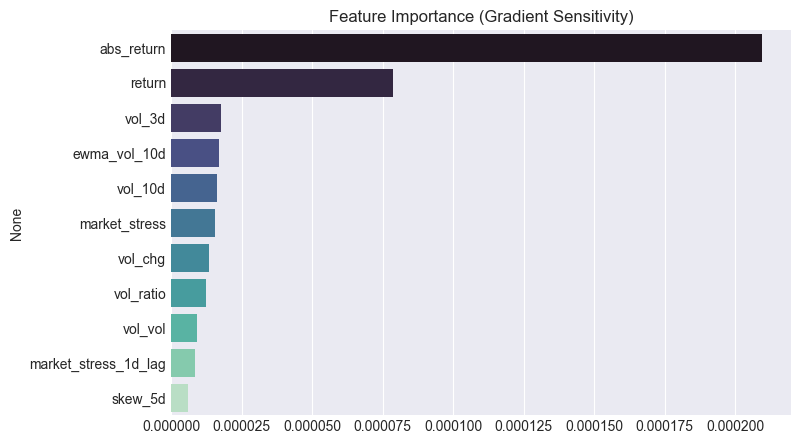

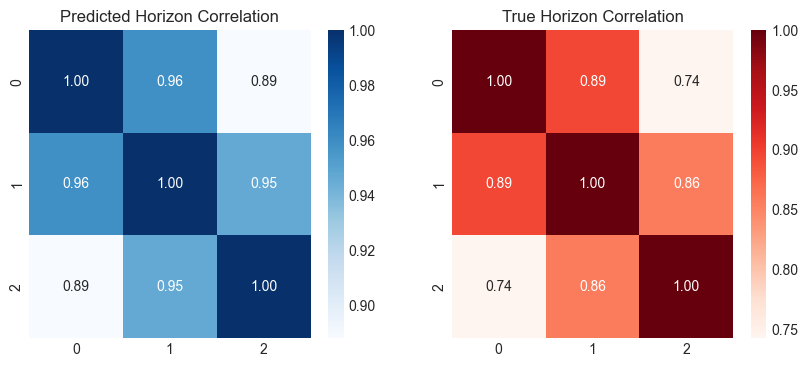

In [13]:
# ============================================================
# 🧠 Feature importance (gradient-based sensitivity)
# ============================================================
def feature_importance(model, cfg, sample_batch, feature_names):
    model.eval()
    t_id, X, y = sample_batch
    X = X.clone().detach().requires_grad_(True)
    out = model(t_id, X)
    loss = torch.mean(out**2)
    loss.backward()
    grads = X.grad.abs().mean(dim=(0,1)).cpu().numpy()
    return pd.Series(grads, index=feature_names).sort_values(ascending=False)

# Use one batch from val_loader_A for feature importance
batch = next(iter(val_loader))
imp_series = feature_importance(model, cfg, batch, ["return"] + (cfg.extra_features or []))

plt.figure(figsize=(8,5))
sns.barplot(x=imp_series.values, y=imp_series.index, palette="mako")
plt.title("Feature Importance (Gradient Sensitivity)")
plt.show()

# ============================================================
# 🔗 Horizon correlation heatmaps
# ============================================================
def plot_horizon_correlation(preds, trues, horizons):
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    corr_p = np.corrcoef(preds.T)
    corr_t = np.corrcoef(trues.T)
    sns.heatmap(corr_p, annot=True, fmt=".2f", ax=ax[0], cmap="Blues")
    sns.heatmap(corr_t, annot=True, fmt=".2f", ax=ax[1], cmap="Reds")
    ax[0].set_title("Predicted Horizon Correlation")
    ax[1].set_title("True Horizon Correlation")
    plt.show()

plot_horizon_correlation(preds_A, trues_A, cfg.horizons)

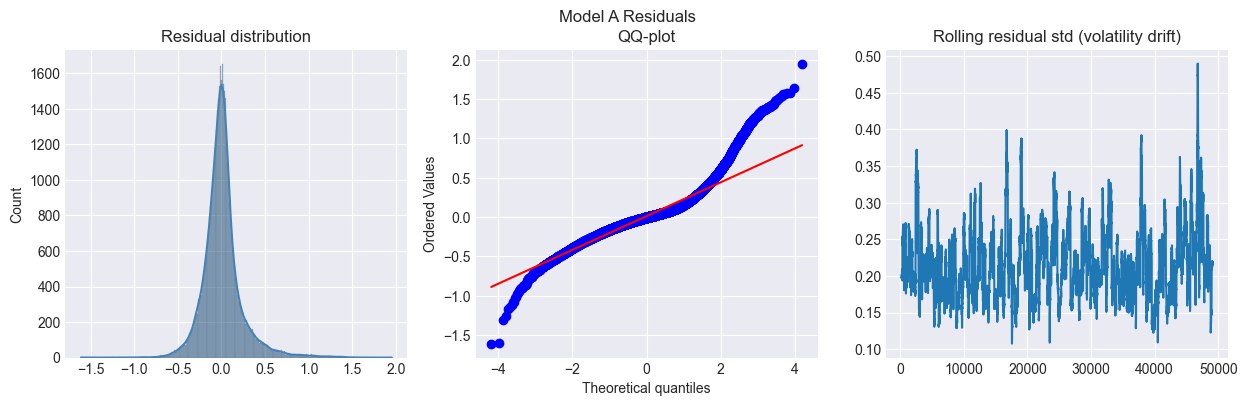

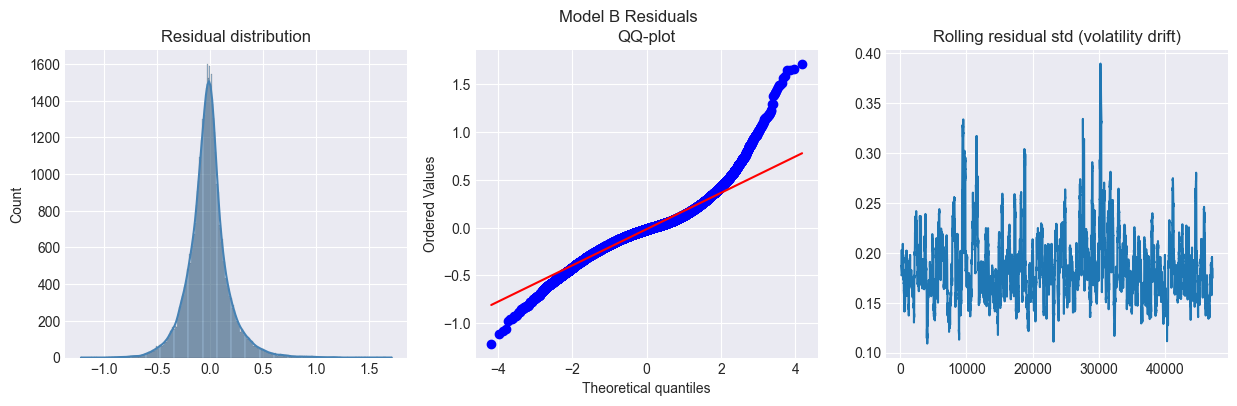

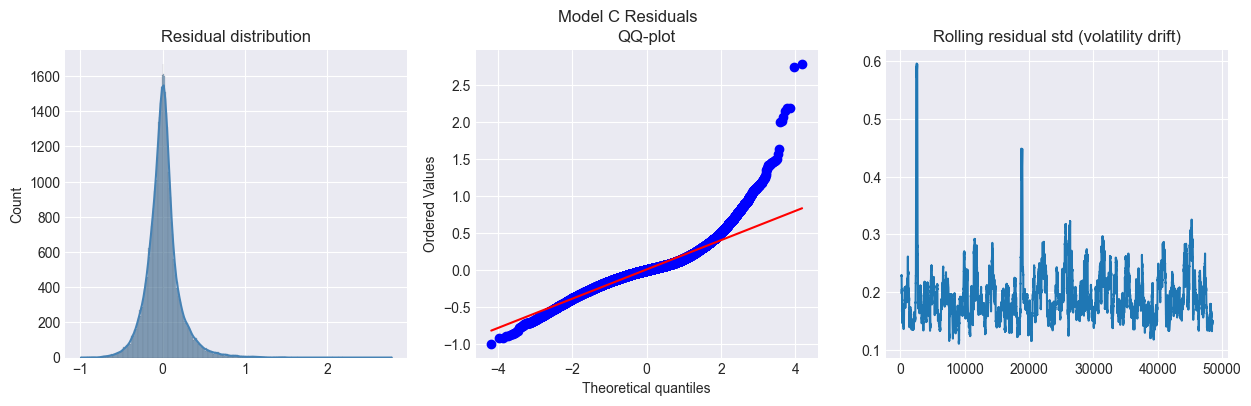

In [15]:
# ============================================================
# 📉 Residual diagnostics
# ============================================================
def plot_residual_diagnostics(trues, preds, title=""):
    resid = trues.flatten() - preds.flatten()
    fig, axs = plt.subplots(1,3,figsize=(15,4))

    sns.histplot(resid, kde=True, ax=axs[0], color="steelblue")
    axs[0].set_title("Residual distribution")

    st.probplot(resid, dist="norm", plot=axs[1])
    axs[1].set_title("QQ-plot")

    pd.Series(resid).rolling(200).std().plot(ax=axs[2])
    axs[2].set_title("Rolling residual std (volatility drift)")
    plt.suptitle(title)
    plt.show()

plot_residual_diagnostics(trues_A, preds_A, "Model A Residuals")
plot_residual_diagnostics(trues_B, preds_B, "Model B Residuals")
plot_residual_diagnostics(trues_C, preds_C, "Model C Residuals")

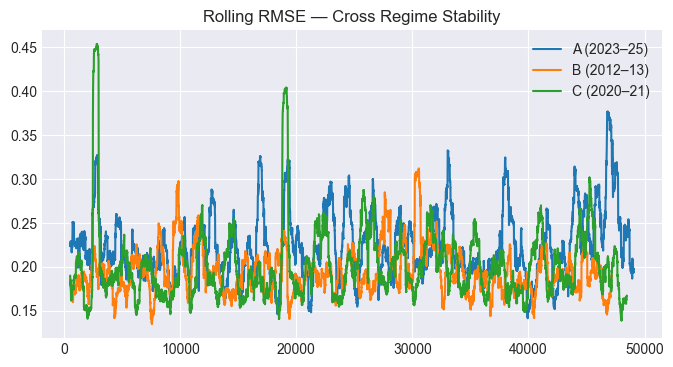

In [16]:
# ============================================================
# 📅 Rolling RMSE to test stability over time
# ============================================================
def rolling_rmse(trues, preds, window=500):
    e = (trues.flatten() - preds.flatten())**2
    return pd.Series(e).rolling(window).mean().pow(0.5)

plt.figure(figsize=(8,4))
plt.plot(rolling_rmse(trues_A, preds_A), label="A (2023–25)")
plt.plot(rolling_rmse(trues_B, preds_B), label="B (2012–13)")
plt.plot(rolling_rmse(trues_C, preds_C), label="C (2020–21)")
plt.legend(); plt.title("Rolling RMSE — Cross Regime Stability")
plt.show()

In [17]:
# ============================================================
# ⚖️ Compute cross-slice robustness
# ============================================================
def compute_robustness(*metric_dfs, metric="MSE"):
    vals = [df[metric].mean() for df in metric_dfs]
    mean_v = np.mean(vals)
    std_v = np.std(vals)
    return 1 - (std_v / mean_v)

robustness_mse = compute_robustness(metrics_A, metrics_B, metrics_C, metric="MSE")
robustness_mae = compute_robustness(metrics_A, metrics_B, metrics_C, metric="MAE")

print("\n🧩 Robustness Score:")
print(f"  MSE-based: {robustness_mse:.3f}")
print(f"  MAE-based: {robustness_mae:.3f}")


🧩 Robustness Score:
  MSE-based: 0.872
  MAE-based: 0.959
